In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr

data_small = pd.read_csv('city_market_tracker.tsv', sep='\t')
data_small = data_small.sort_values('period_begin')
data_big = pd.read_csv('city_market_tracker.tsv000', sep='\t')
data_big = data_big.sort_values('period_begin')
# data.info()

# col_names = data.columns.tolist()
# print(col_names)

In [2]:
def lagrange_interpolation(x, y):
    """
    Returns a function that evaluates the Lagrange polynomial defined by given nodes.
    
    Parameters:
    - x_nodes: 1D array-like of interpolation nodes
    - y_nodes: 1D array-like of function values at the nodes
    
    Returns:
    - A function P(x_val) that evaluates the Lagrange polynomial at x_val.
    """
    x_nodes = np.array(x)
    y_nodes = np.array(y)
    n = len(x_nodes)
    
    def P(x_val):
        total = 0
        for j in range(n):
            term = y_nodes[j]
            for i in range(n):
                if i != j:
                    term *= (x_val - x[i]) / (x[j] - x[i])
            total += term
        return total
    
    return P

In [3]:
def plot_city(data, city_name, state_code):
    """
    Plots Cubic Spline and Lagrange interpolation (using Chebyshev nodes) for a given city's 
    median sale price over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado) to disambiguate cities.
    - num_nodes: Number of Chebyshev nodes to use for the Lagrange interpolation.
    """
    # Obtain data for city in a specific state
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    # Convert period_begin to datetime and sort data
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = city_data.sort_values('period_begin')

    # Remove duplicate dates by averaging sale prices
    city_data = city_data.groupby('period_begin', as_index=False)['median_sale_price'].mean()

    # Convert dates to numerical format
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data['median_sale_price'].values

    # Check if x is strictly increasing
    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Fit cubic spline interpolation
    cubic_spline = CubicSpline(x, y, bc_type='natural')
    
    # Get the number of entries for Chebyshev Nodes
    num_nodes = len(city_data)

    # Determine number of Chebyshev nodes
    n_nodes = min(num_nodes, len(x))
    a, b = x.min(), x.max()

    # Compute Chebyshev nodes in [a, b]
    k = np.arange(n_nodes)
    cheb_nodes = 0.5*(a + b) + 0.5*(b - a) * np.cos((2*k + 1) / (2*n_nodes) * np.pi)
    
    # Get the corresponding y values at Chebyshev nodes using linear interpolation on the original data
    cheb_values = np.interp(cheb_nodes, x, y)

    # Create Lagrange interpolation function using Chebyshev nodes and their corresponding values
    lagrange_poly = lagrange_interpolation(cheb_nodes, cheb_values)

    # Generate smooth x values for plotting
    x_smooth = np.linspace(a, b, 500)
    y_cubic = cubic_spline(x_smooth)  # Evaluate cubic spline
    # Evaluate Lagrange polynomial at each smooth x value
    y_lagrange = np.array([lagrange_poly(val) for val in x_smooth])

    # Convert smooth x values back to datetime for plotting
    dates_smooth = [pd.Timestamp.fromordinal(int(val)) for val in x_smooth]

    # Plot original data points
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data['median_sale_price'], color='black', marker='o', linestyle='-', linewidth=2, label='Real Data', alpha=0.75)

    # Plot cubic spline
    plt.plot(dates_smooth, y_cubic, color='red', linestyle='--', linewidth=1, label='Cubic Spline Interpolation')

    # Plot Lagrange interpolation (using Chebyshev nodes)
    plt.plot(dates_smooth, y_lagrange, color='blue', linestyle='--', linewidth=1, label=f'Lagrange Interpolation (Chebyshev, n={n_nodes})')

    # Formatting
    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

In [4]:
def plot_city_original(data, city_name, state_code):
    """
    Plots Cubic Spline and plain Lagrange interpolation
    for a given city's median sale price over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado).
    """
    # obtain and sort data
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = (
        city_data
        .sort_values('period_begin')
        .groupby('period_begin', as_index=False)['median_sale_price']
        .mean()
    )

    # Convert to numeric x, y
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data['median_sale_price'].values

    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Cubic spline 
    cubic_spline = CubicSpline(x, y, bc_type='natural')

    # Lagrange
    lagrange_poly = lagrange_interpolation(x, y)

    # Smooth x for plotting
    a, b = x.min(), x.max()
    x_smooth = np.linspace(a, b, 500)
    y_cubic    = cubic_spline(x_smooth)
    y_lagrange = np.array([lagrange_poly(xx) for xx in x_smooth])
    dates_smooth = [pd.Timestamp.fromordinal(int(xx)) for xx in x_smooth]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data['median_sale_price'], 'o-', color='black', alpha=0.75, linewidth=2, label='Real Data')
    plt.plot(dates_smooth, y_cubic,  '--', linewidth=1, color='red',    label='Cubic Spline')
    plt.plot(dates_smooth, y_lagrange, '--', linewidth=1, color='blue',   label=f'Lagrange')

    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(f'Cubic Spline vs. Lagrange in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

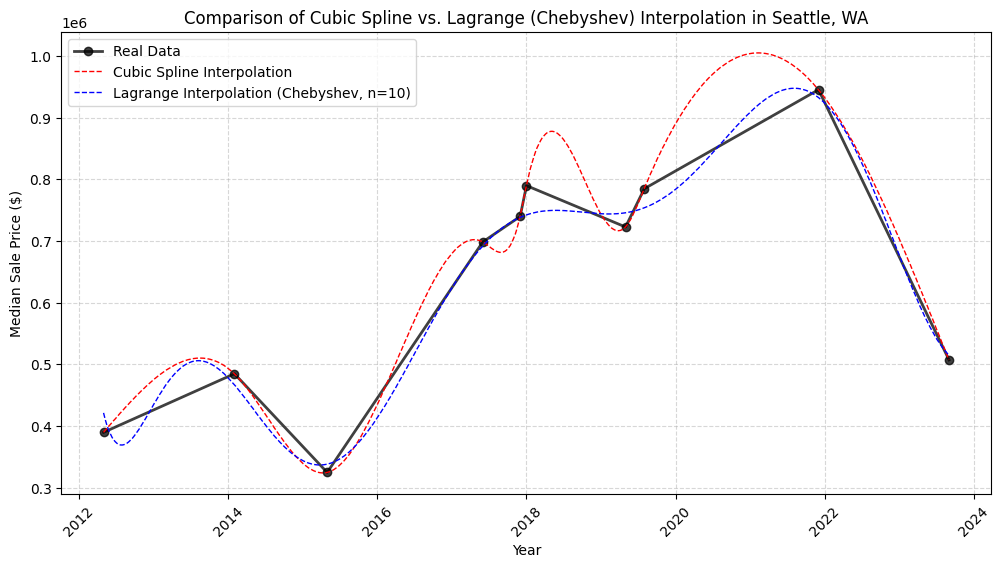

In [5]:
city = 'Seattle'
code = 'WA'

plot_city(data_small, city, code)
# plot_city_original(data, city, code)

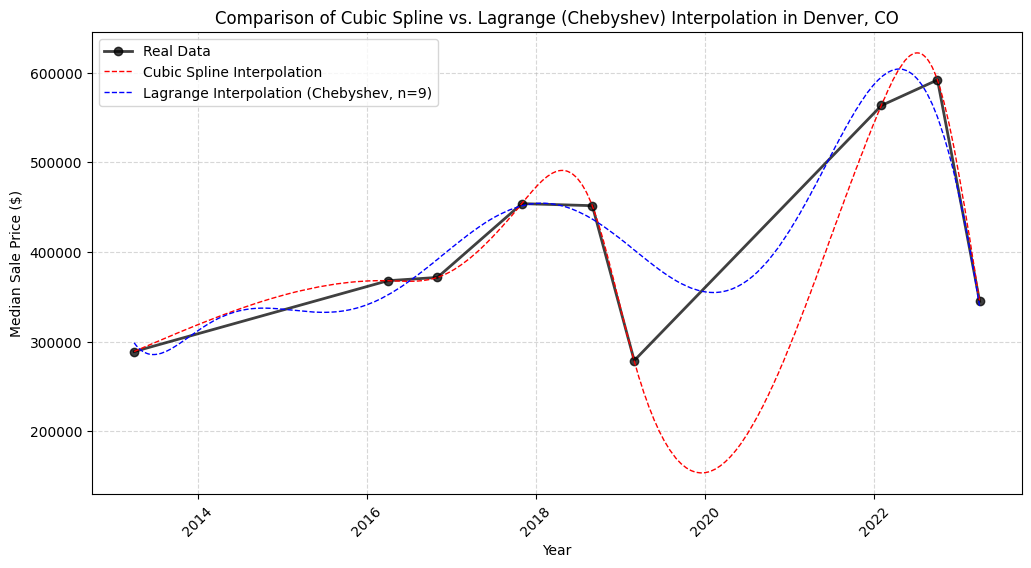

In [6]:
city = 'Denver'
code = 'CO'

plot_city(data_small, city, code)
# plot_city_original(data, city, code)

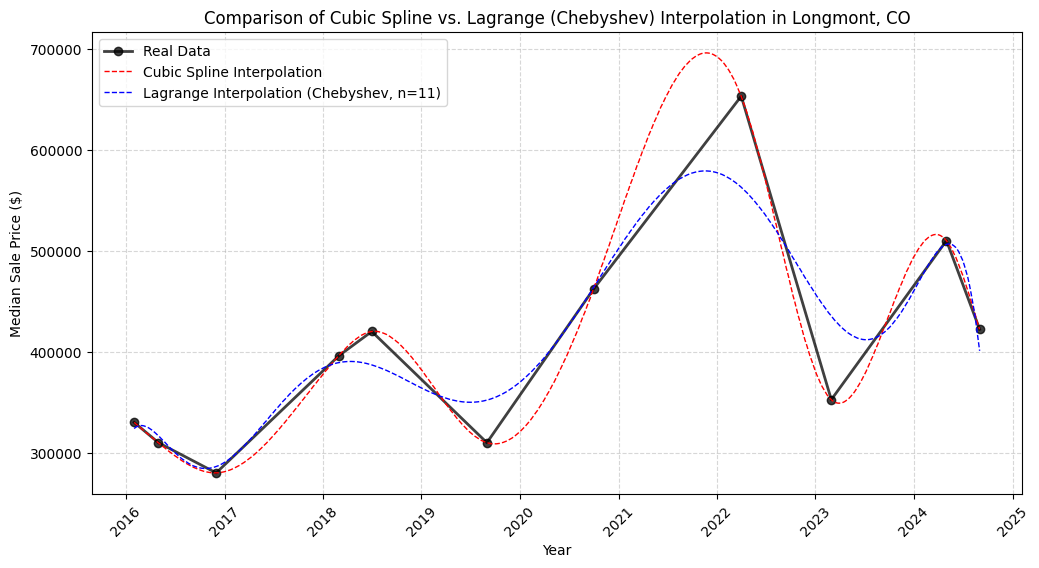

In [7]:
city = 'Longmont'
code = 'CO'

plot_city(data_small, city, code)
# plot_city_original(data, city, code)

$x^{(0)}_k = \cos(\frac{2k + 1}{2n} \pi)$ for k = 0, 1, ..., n-1

$x_k = \frac{a + b}{2} + \frac{b - a}{2} x^{(0)}_k$

In [8]:
# Get columns to work with correlations over whole dataset
col_names = data_big.columns.tolist()
del col_names[:13]
del col_names[42:]
print(col_names)

['median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy', 'median_list_price', 'median_list_price_mom', 'median_list_price_yoy', 'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf', 'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold', 'homes_sold_mom', 'homes_sold_yoy', 'pending_sales', 'pending_sales_mom', 'pending_sales_yoy', 'new_listings', 'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy', 'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy', 'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom', 'sold_above_list_yoy', 'price_drops', 'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks', 'off_market_in_two_weeks_mom', 'off_market_in_two_weeks_yoy']


In [9]:
def bucket_data(city_data, column='median_sale_price', bucket_size='Q'):
    """
    Bucket the data by time periods and compute the mean for each bucket.

    Parameters:
    - city_data: DataFrame containing the city's data
    - bucket_size: Time period to bucket by (e.g., 'QE' for quarterly, 'ME' for monthly, 'YE' for yearly)

    Returns:
    - Bucketed DataFrame with period_begin and median_sale_price
    """
    # Convert to datetime and set as index
    city_data = city_data.copy()
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data.set_index('period_begin', inplace=True)

    # Resample by bucket size and take mean
    bucketed = city_data.resample(bucket_size)[column].mean().reset_index()

    return bucketed

def plot_city(data, city_name, state_code, column='median_sale_price', bucket_size='QE'):
    """
    Plots Cubic Spline and Lagrange interpolation (using Chebyshev nodes) for a given city's
    median sale price or number of homes sold over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado).
    - column: String, column name to plot ('median_sale_price' or 'homes_sold').
    """
    # Filter data for the selected city and state
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    # Convert period_begin to datetime and sort data
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = city_data[city_data['period_begin'].dt.year < 2024]
    city_data = city_data.sort_values('period_begin')

    # Remove duplicate dates by averaging the selected column
    city_data = city_data.groupby('period_begin', as_index=False)[column].mean()

    # Bucket the data if specified
    if bucket_size:
        city_data = bucket_data(city_data, column, bucket_size)
        bucket_label = f" (Bucketed by {bucket_size})"
    else:
        bucket_label = ""

    # Convert dates to numerical format
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data[column].values

    # Check if x is strictly increasing
    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Get the number of entries for Chebyshev Nodes
    num_nodes = len(city_data)

    # Determine number of Chebyshev nodes
    n_nodes = min(num_nodes, len(x))
    a, b = x.min(), x.max()

    # Compute Chebyshev nodes in [a, b]
    k = np.arange(n_nodes)
    cheb_nodes = 0.5*(a + b) + 0.5*(b - a) * np.cos((2*k + 1) / (2*n_nodes) * np.pi)

    # Get the corresponding y values at Chebyshev nodes using linear interpolation on the original data
    cheb_values = np.interp(cheb_nodes, x, y)

    # Create Lagrange interpolation function using Chebyshev nodes and their corresponding values
    lagrange_poly = lagrange_interpolation(cheb_nodes, cheb_values)

    # Generate smooth x values for plotting
    x_smooth = np.linspace(a, b, 500)

    # Evaluate Lagrange polynomial at each smooth x value
    y_lagrange = np.array([lagrange_poly(val) for val in x_smooth])

    # Convert smooth x values back to datetime for plotting
    dates_smooth = [pd.Timestamp.fromordinal(int(val)) for val in x_smooth]

    # Plot original data points
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data[column], color='black', marker='o', linestyle='-', linewidth=2, label=f'Real Data{bucket_label}', alpha=0.75)

    # Plot Lagrange interpolation (using Chebyshev nodes)
    plt.plot(dates_smooth, y_lagrange, color='green', linestyle='--', linewidth=1, label=f'Lagrange Interpolation (Chebyshev, n={n_nodes})')

    # Formatting
    plt.xlabel('Year')
    if column == 'median_sale_price':
        plt.ylabel('Median Sale Price ($)')
        plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation for Median Sale Price in {city_name}, {state_code}')
    elif column == 'homes_sold':
        plt.ylabel('Number of Homes Sold')
        plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation for Number of Homes Sold in {city_name}, {state_code}')
    elif column == 'inventory':
        plt.ylabel('Number of Total Homes on Market')
        plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation for Number of Total Homes on Market in {city_name}, {state_code}')
    elif column == 'new_listings':
        plt.ylabel('Number of New Listings')
        plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation for Number of New Listings in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [10]:
def compute_correlation(data, city_name, state_code, column1, column2, bucket_size='QE'):
    """
    Computes and plots Pearson and Spearman correlations between median_sale_price and homes_sold.

    Parameters:
    - data: DataFrame containing housing data.
    - city_name: Name of the city (e.g., 'Seattle').
    - state_code: State abbreviation (e.g., 'WA').
    - bucket_size: Time period for bucketing (e.g., 'QE' for quarter-end).
    """
    # Filter data for the city
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    # Convert to datetime and sort
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = city_data[city_data['period_begin'].dt.year < 2024]
    city_data = city_data.sort_values('period_begin')

    # Bucket data (e.g., quarterly averages)
    city_data = city_data.set_index('period_begin').resample(bucket_size).agg({
        column1: 'mean',
        column2: 'mean'
    }).reset_index()

    # Drop rows with missing values
    city_data = city_data.dropna()

    # Compute Pearson and Spearman correlations
    pearson_correlation, pearson_p = pearsonr(city_data[column1], city_data[column2])

    # Output correlation if statistically significant
    if pearson_p < 0.05:
        correlation = f"Pearson Correlation ({column2}): {pearson_correlation:.3f} (p-value: {pearson_p:.3f})"

        print(correlation)

        # Plot the relationship
        plt.figure(figsize=(10, 6))
        plt.scatter(
            city_data[column1],
            city_data[column2],
            alpha=0.6,
            label=f"{city_name}, {state_code}"
        )

        # Add regression line (for Pearson)
        z = np.polyfit(city_data[column1], city_data[column2], 1)
        p = np.poly1d(z)
        plt.plot(
            city_data[column1],
            p(city_data[column1]),
            color='red',
            linestyle='--',
            label=f"Linear Fit (r = {pearson_correlation:.2f})"
        )

        plt.xlabel(column1)
        plt.ylabel(column2)
        plt.title(f"{column1} vs. {column2} in {city_name}, {state_code}\nPearson r = {pearson_correlation:.2f}")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("P-value is greater or equal to 0.05, and correlation is not statistically significant.")


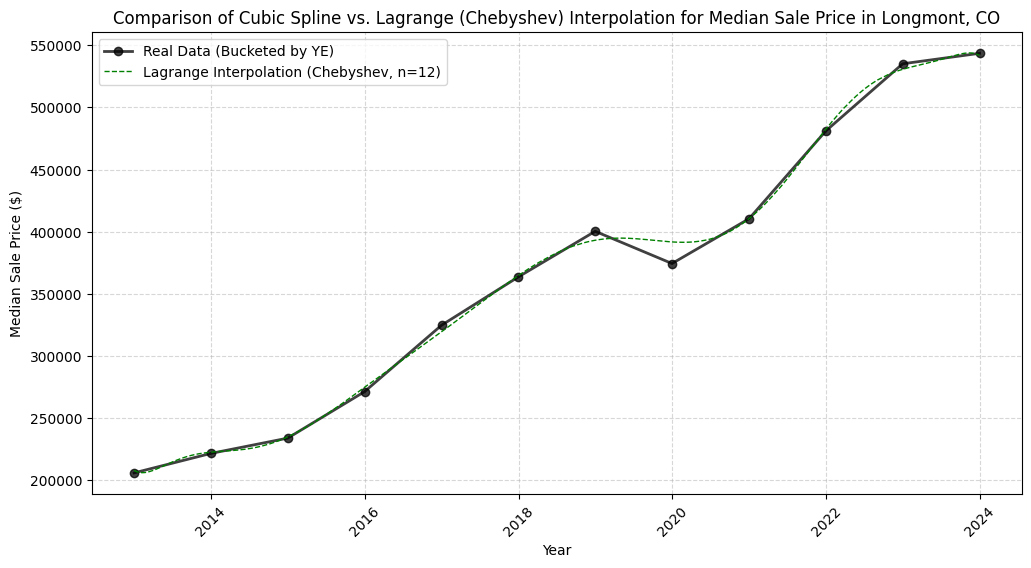

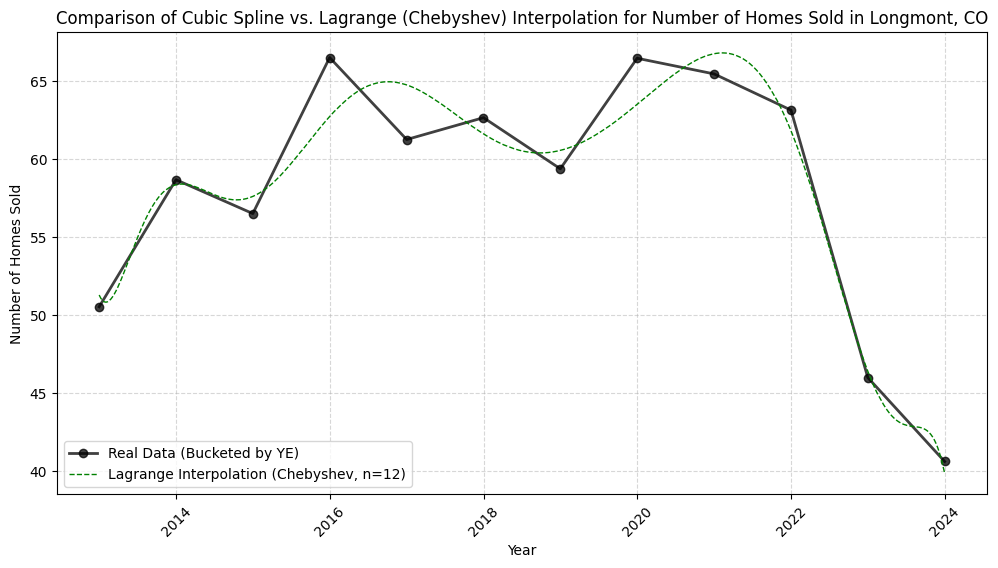

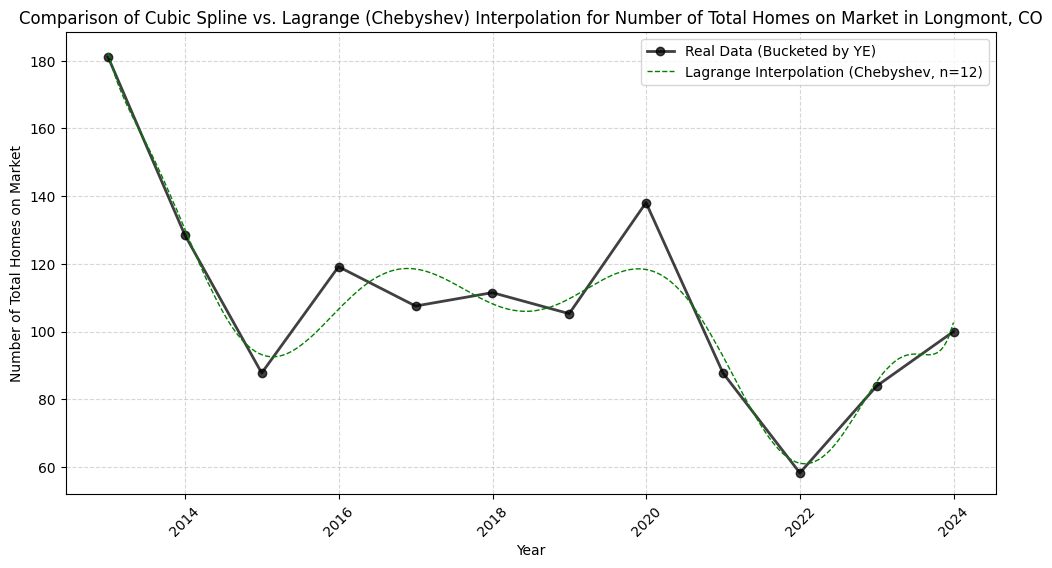

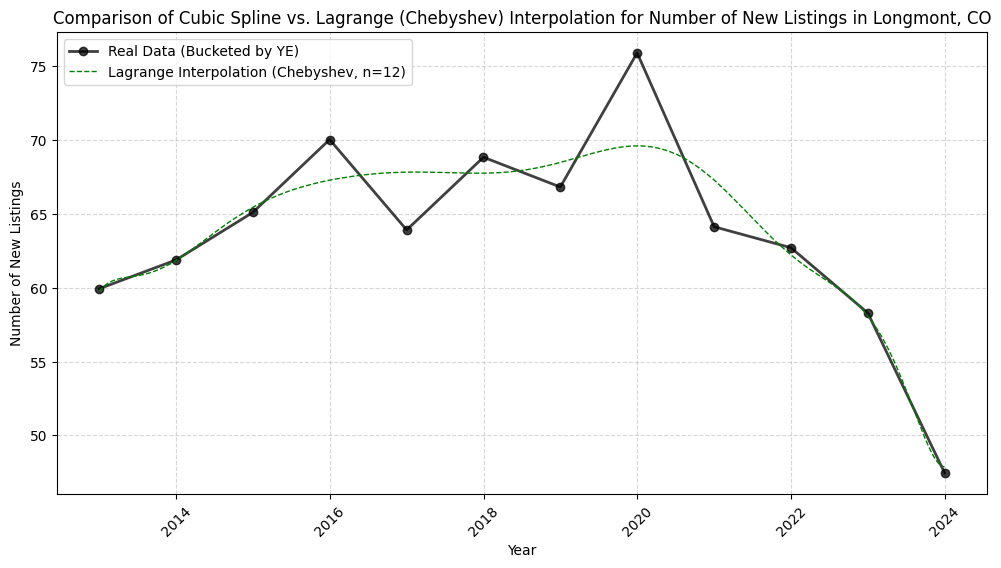

In [11]:
city = 'Longmont'
code = 'CO'

# Use newly bucketed data to plot initially considered parameters
plot_city(data_big, city, code, column='median_sale_price', bucket_size='YE')
plot_city(data_big, city, code, column='homes_sold', bucket_size='YE')
plot_city(data_big, city, code, column='inventory', bucket_size='YE')
plot_city(data_big, city, code, column='new_listings', bucket_size='YE')

P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (inventory): -0.619 (p-value: 0.032)


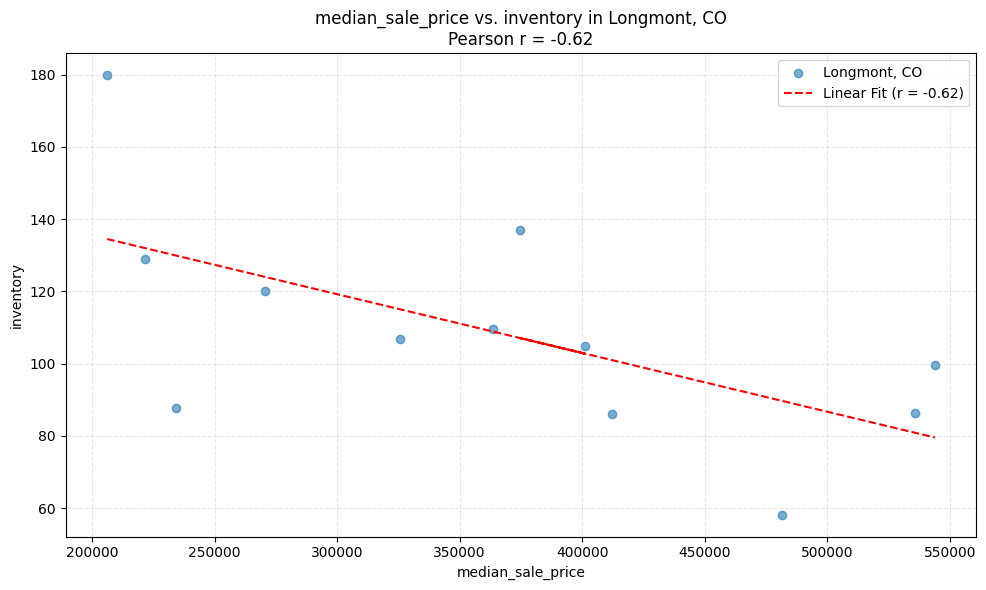

P-value is greater or equal to 0.05, and correlation is not statistically significant.


In [12]:
# Compute correlations between parameters and median_sale_price
compute_correlation(data_big, city, code, column1='median_sale_price', column2='homes_sold', bucket_size='YE')
compute_correlation(data_big, city, code, column1='median_sale_price', column2='inventory', bucket_size='YE')
compute_correlation(data_big, city, code, column1='median_sale_price', column2='new_listings', bucket_size='YE')

P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (homes_sold_yoy): -0.786 (p-value: 0.002)


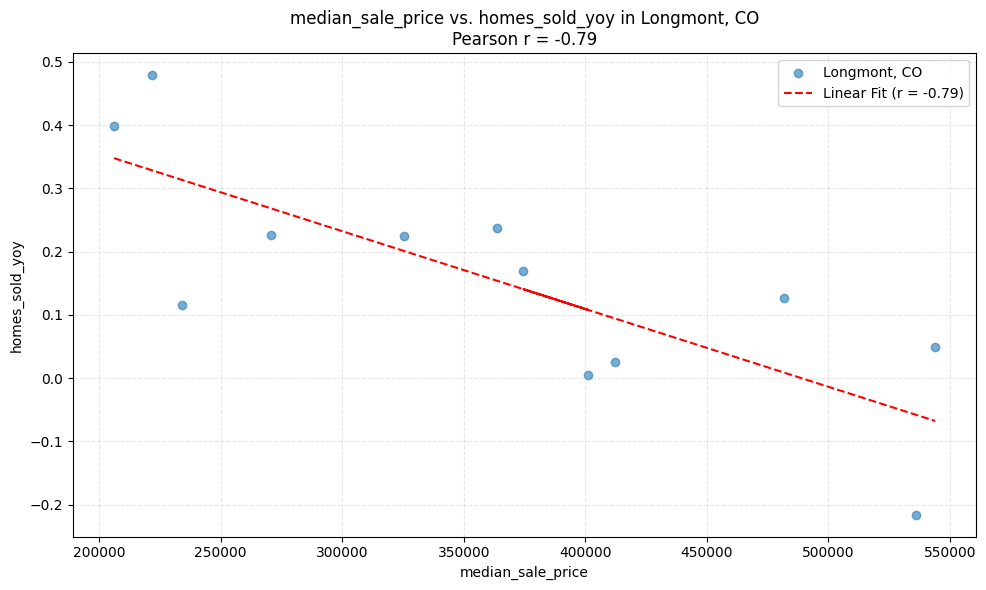

Pearson Correlation (pending_sales): -0.752 (p-value: 0.005)


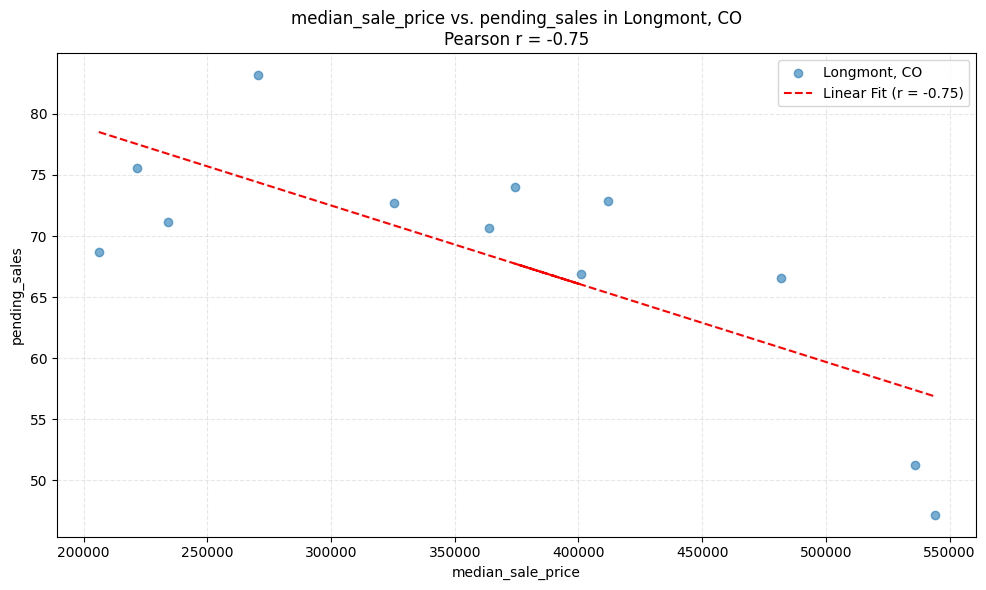

P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (pending_sales_yoy): -0.731 (p-value: 0.007)


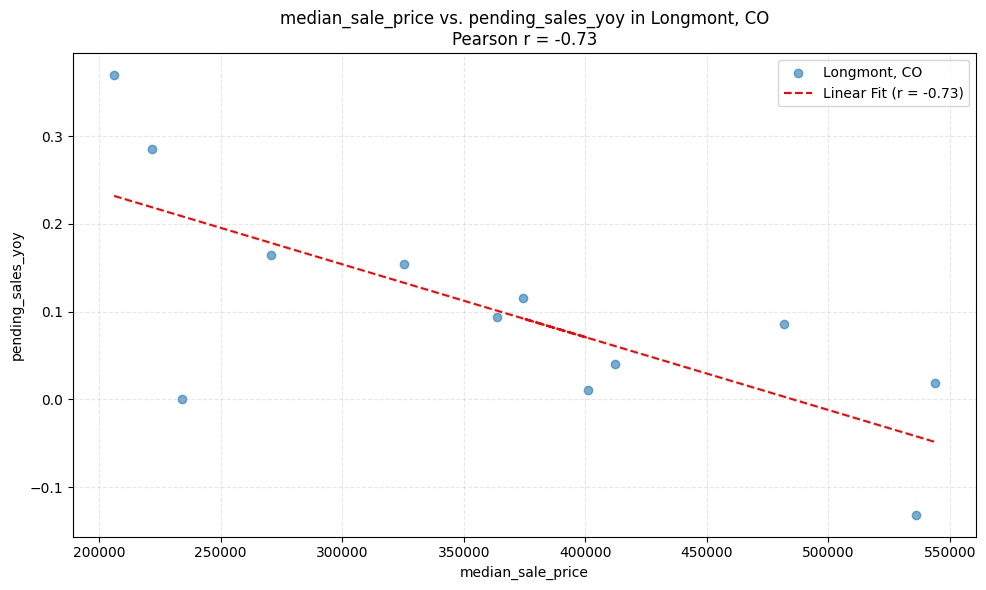

P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (inventory): -0.619 (p-value: 0.032)


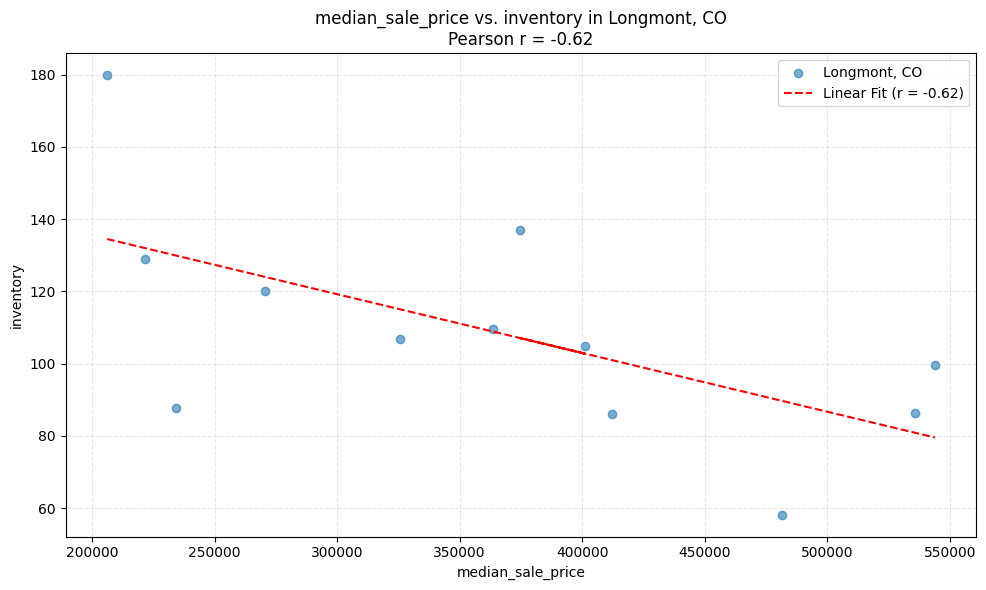

P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (inventory_yoy): 0.600 (p-value: 0.039)


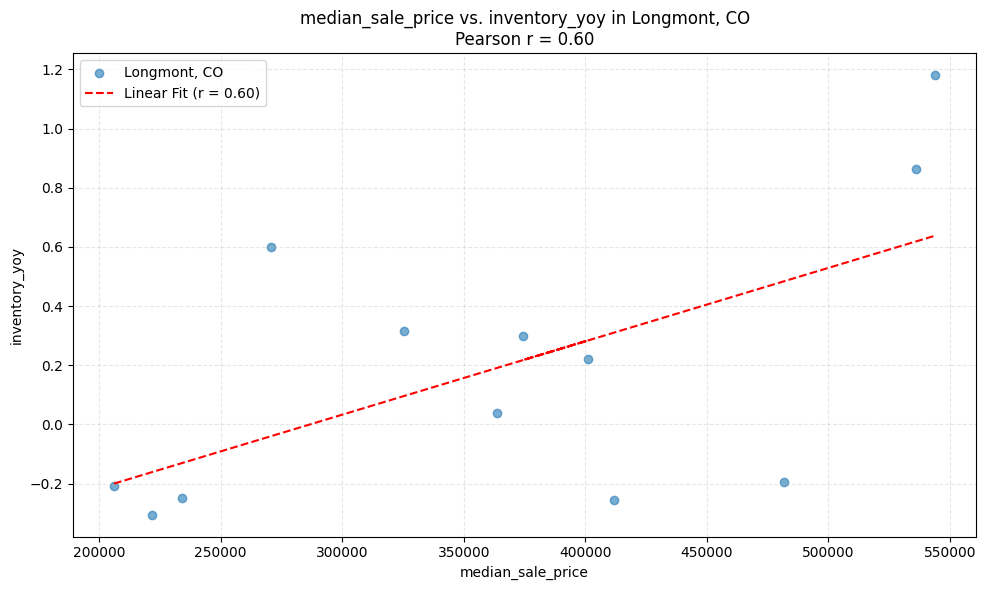

P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
Pearson Correlation (months_of_supply_yoy): 0.701 (p-value: 0.011)


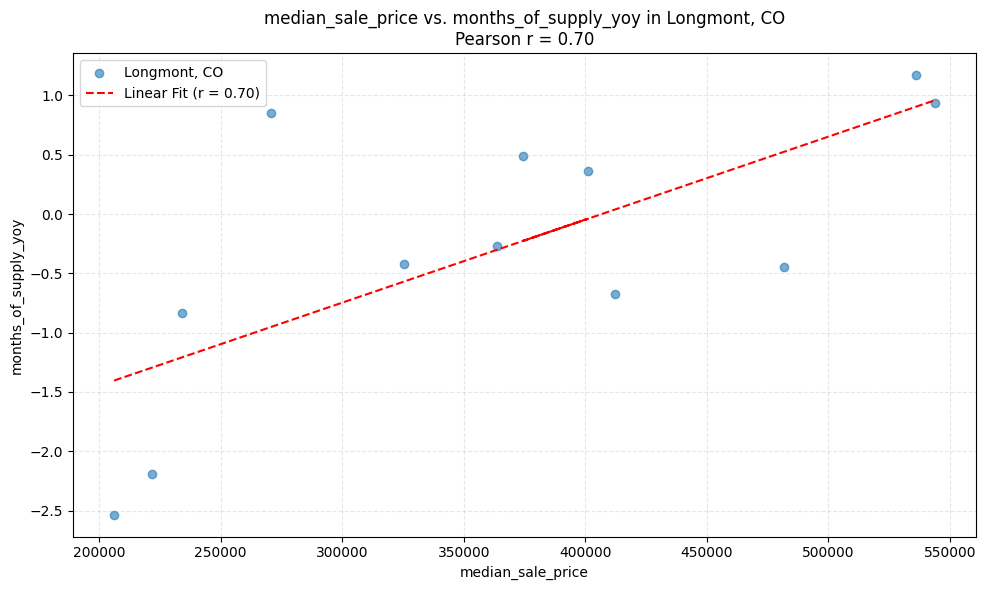

Pearson Correlation (avg_sale_to_list): 0.604 (p-value: 0.037)


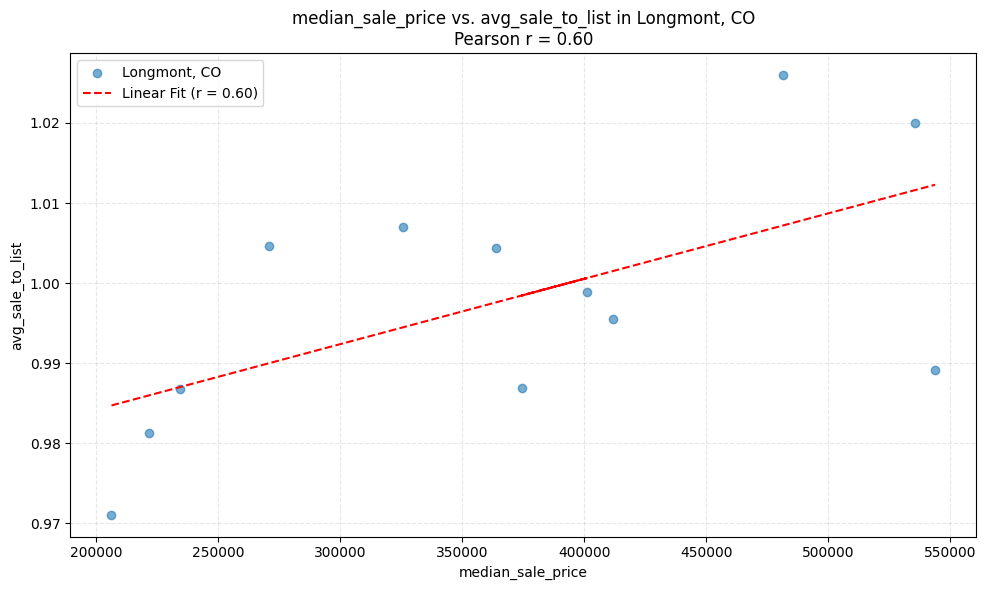

P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.
P-value is greater or equal to 0.05, and correlation is not statistically significant.


In [13]:
# Find other parameters correlated with median_sale_price
for col in col_names:
    if not col.startswith('median' or 'period'):
        compute_correlation(data_big, city, code, column1='median_sale_price', column2=col, bucket_size='YE')